In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir '/content/drive/My Drive/Packages'
!mkdir '/content/drive/My Drive/Packages/OpenVINO/nanodet'

In [2]:
package_path = '/content/packages'
os.symlink('/content/drive/My Drive/Packages/OpenVINO/nanodet', package_path)
sys.path.append(package_path)

In [3]:
!pip install -r '/content/drive/MyDrive/openvino_notebooks-main/requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Ignoring tensorflow-macos: markers 'sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "darwin" and platform_machine != "arm64"' don't match your environment
Ignoring torch: markers 'sys_platform == "darwin"' don't match your environment
Ignoring torchvision: markers 'sys_platform == "darwin"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.5/904.5 KB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [4]:
%cd '/content/drive/MyDrive/openvino_notebooks-main/notebooks/nanodet'

/content/drive/MyDrive/openvino_notebooks-main/notebooks/nanodet


# NanoDet

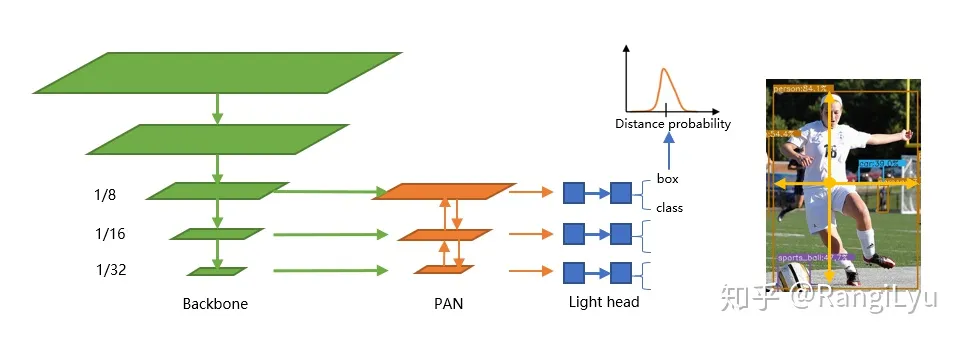

NanoDet is a FCOS-style one-stage anchor-free object detection model which using Generalized Focal Loss as classification and regression loss.

In NanoDet-Plus, we propose a novel label assignment strategy with a simple assign guidance module (AGM) and a dynamic soft label assigner (DSLA) to solve the optimal label assignment problem in lightweight model training. We also introduce a light feature pyramid called Ghost-PAN to enhance multi-layer feature fusion. These improvements boost previous NanoDet's detection accuracy by 7 mAP on COCO dataset.

Real-time object detection is often used as a key component in computer vision systems. Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.

This tutorial demonstrates step-by-step instructions on how to run PyTorch NanoDet model with OpenVINO.

The tutorial consists of the following steps:

Prepare PyTorch model\
Validate original model\
Convert PyTorch model to ONNX\
Convert ONNX model to OpenVINO IR\
Validate converted model\
Download and prepare dataset\
Evaluating performance by AP (average Precision).

# Get Pytorch model

Generally, PyTorch models represent an instance of the torch.nn.Module class, initialized by a state dictionary with model weights. We will use the NanoDet model pre-trained on a COCO dataset, which is available in this [repo](https://github.com/RangiLyu/nanodet). Typical steps to obtain pre-trained model:





1.   Create instance of model class.
2.   Load checkpoint state dict, which contains pre-trained model weights.
3.   Turn model to evaluation for switching some operations to inference mode.

In this case, the model creators provide a tool that enables converting the NanoDet model to ONNX, so we do not need to do these steps manually.



# Prerequisites

In [5]:
import sys
from pathlib import Path
sys.path.append("../utils")
from notebook_utils import download_file

In [6]:
# Clone nanodet repo
if not Path('nanodet').exists():
    !git clone https://github.com/RangiLyu/nanodet
%cd nanodet

/content/drive/My Drive/openvino_notebooks-main/notebooks/nanodet/nanodet


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python setup.py develop

In [ ]:
!pip install onnxruntime

In [ ]:
# Download pretrained model weights
MODEL_LINK = "https://drive.google.com/u/0/uc?id=1ZkYucuLusJrCb_i63Lid0kYyyLvEiGN3&export=download"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)

# Check model inference

Pytorch model inference and save image as result

In [11]:
from nanodet.util import cfg, load_config, Logger

In [12]:
CONFIG_PATH = 'config/legacy_v0.x_configs/nanodet-m.yml'
MODEL_PATH = 'model/nanodet_m.ckpt'
IMAGE_PATH = '../../data/image/coco.jpg'

In [13]:
load_config(cfg, CONFIG_PATH)
logger = Logger(-1, use_tensorboard=False)

In [14]:
from demo.demo import Predictor

In [ ]:
predictor = Predictor(cfg, MODEL_PATH, logger, device='cpu')

In [ ]:
meta, res = predictor.inference(IMAGE_PATH)

In [17]:
import cv2
from nanodet.util import overlay_bbox_cv

from IPython.display import display
from PIL import Image

def cv2_imshow(a, convert_bgr_to_rgb=True):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
        a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
        convert_bgr_to_rgb: switch to convert BGR to RGB channel.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if convert_bgr_to_rgb and a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [18]:
result = overlay_bbox_cv(meta['raw_img'][0], res[0], cfg.class_names, score_thresh=0.35)

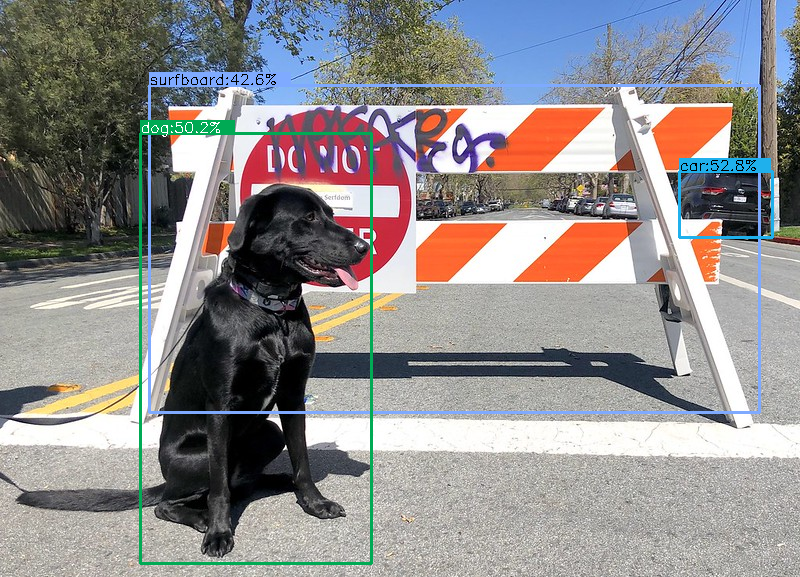

In [19]:
imshow_scale = 1.0
cv2_imshow(cv2.resize(result, None, fx=imshow_scale, fy=imshow_scale))

# Export to ONNX 

In [ ]:
!python tools/export_onnx.py --cfg_path $CONFIG_PATH --model_path $MODEL_PATH

# Convert ONNX Model to OpenVINO Intermediate Representation (IR)
While ONNX models are directly supported by OpenVINO runtime, it can be useful to convert them to IR format to take the advantage of OpenVINO optimization tools and features. The mo.convert_model python function in OpenVINO Model Optimizer can be used for converting the model. The function returns instance of OpenVINO Model class, which is ready to use in Python interface. However, it can also be serialized to OpenVINO IR format for future execution.

In [21]:
from openvino.tools import mo
from openvino.runtime import serialize

model = mo.convert_model('nanodet.onnx')
# serialize model for saving IR
serialize(model, 'model/nanodet-m.xml')

# Verify model inference
The pipeline consists of preprocessing step, inference of OpenVINO model, and results post-processing to get bounding boxes.

Preprocessing
Model input is a tensor with the [1, 3, 320, 320] shape in N, C, H, W format, where

N - number of images in batch (batch size)\
C - image channels\
H - image height\
W - image width

In [22]:
device = 'cpu'
from openvino.runtime import Core
core = Core()
# read converted model
model = core.read_model('model/nanodet-m.xml')
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')

In [23]:
import math
import torch
import numpy as np
from nanodet.data.transform import Pipeline
from nanodet.data.transform.warp import warp_boxes
from nanodet.data.collate import naive_collate
from nanodet.data.batch_process import stack_batch_img
from nanodet.model.head.gfl_head import Integral
from nanodet.util import distance2bbox
from nanodet.model.module.nms import multiclass_nms

In [45]:
def inference(img):
    #Pre-Processing
    img_info = {"id": 0}
    if isinstance(img, str):
        img_info["file_name"] = os.path.basename(img)
        img = cv2.imread(img)
    else:
        img_info["file_name"] = None
    height, width = img.shape[:2]
    img_info["height"] = height
    img_info["width"] = width
    meta = dict(img_info=img_info, raw_img=img, img=img)
    pipeline = Pipeline(cfg.data.val.pipeline, False)
    meta = pipeline(None, meta, cfg.data.val.input_size)
    meta["img"] = torch.from_numpy(meta["img"].transpose(2, 0, 1)).to(device)
    meta = naive_collate([meta])
    meta["img"] = stack_batch_img(meta["img"], divisible=32)

    #Inferencing
    output_blob = compiled_model.output(0)
    preds = compiled_model(meta["img"])[output_blob]
    preds = torch.from_numpy(preds).to(device)
    results = post_process(preds, meta)
    # with torch.no_grad():
    #     results = self.model.inference(meta)
    return meta, results

# Postprocessing

In [25]:
num_classes = 80
reg_max = 7
strides = [8, 16, 32]

distribution_project = Integral(reg_max)

def post_process(preds, meta):
    cls_scores, bbox_preds = preds.split(
        [num_classes, 4 * (reg_max + 1)], dim=-1
    )
    result_list = get_bboxes(cls_scores, bbox_preds, meta, strides)
    det_results = {}
    warp_matrixes = (
        meta["warp_matrix"]
        if isinstance(meta["warp_matrix"], list)
        else meta["warp_matrix"]
    )
    img_heights = (
        meta["img_info"]["height"].cpu().numpy()
        if isinstance(meta["img_info"]["height"], torch.Tensor)
        else meta["img_info"]["height"]
    )
    img_widths = (
        meta["img_info"]["width"].cpu().numpy()
        if isinstance(meta["img_info"]["width"], torch.Tensor)
        else meta["img_info"]["width"]
    )
    img_ids = (
        meta["img_info"]["id"].cpu().numpy()
        if isinstance(meta["img_info"]["id"], torch.Tensor)
        else meta["img_info"]["id"]
    )

    for result, img_width, img_height, img_id, warp_matrix in zip(
        result_list, img_widths, img_heights, img_ids, warp_matrixes
    ):
        det_result = {}
        det_bboxes, det_labels = result
        det_bboxes = det_bboxes.detach().cpu().numpy()
        det_bboxes[:, :4] = warp_boxes(
            det_bboxes[:, :4], np.linalg.inv(warp_matrix), img_width, img_height
        )
        classes = det_labels.detach().cpu().numpy()
        for i in range(num_classes):
            inds = classes == i
            det_result[i] = np.concatenate(
                [
                    det_bboxes[inds, :4].astype(np.float32),
                    det_bboxes[inds, 4:5].astype(np.float32),
                ],
                axis=1,
            ).tolist()
        det_results[img_id] = det_result
    return det_results

###Helper functions for Postprocessing

get_bboxes() function uses the predictions from the model and returns the list of detection bounding boxes and labels



In [26]:
def get_bboxes(cls_preds, reg_preds, img_metas, strides):
    """Decode the outputs to bboxes.
    Args:
        cls_preds (Tensor): Shape (num_imgs, num_points, num_classes).
        reg_preds (Tensor): Shape (num_imgs, num_points, 4 * (regmax + 1)).
        img_metas (dict): Dict of image info.

    Returns:
        results_list (list[tuple]): List of detection bboxes and labels.
    """
    device = cls_preds.device
    b = cls_preds.shape[0]
    input_height, input_width = img_metas["img"].shape[2:]
    input_shape = (input_height, input_width)

    featmap_sizes = [
        (math.ceil(input_height / stride), math.ceil(input_width) / stride)
        for stride in strides
    ]
    # get grid cells of one image
    mlvl_center_priors = []
    for i, stride in enumerate(strides):
        y, x = get_single_level_center_point(
            featmap_sizes[i], stride, torch.float32, device
        )
        strides = x.new_full((x.shape[0],), stride)
        priors = torch.stack([x, y, strides, strides], dim=-1)
        mlvl_center_priors.append(priors.unsqueeze(0).repeat(b, 1, 1))

    center_priors = torch.cat(mlvl_center_priors, dim=1)
    dis_preds = distribution_project(reg_preds) * center_priors[..., 2, None]
    bboxes = distance2bbox(center_priors[..., :2], dis_preds, max_shape=input_shape)
    scores = cls_preds.sigmoid()
    result_list = []
    for i in range(b):
        # add a dummy background class at the end of all labels
        # same with mmdetection2.0
        score, bbox = scores[i], bboxes[i]
        padding = score.new_zeros(score.shape[0], 1)
        score = torch.cat([score, padding], dim=1)
        results = multiclass_nms(
            bbox,
            score,
            score_thr=0.05,
            nms_cfg=dict(type="nms", iou_threshold=0.6),
            max_num=100,
        )
        result_list.append(results)
    return result_list

def get_single_level_center_point(
    featmap_size, stride, dtype, device, flatten=True
):
    """
    Generate pixel centers of a single stage feature map.
    :param featmap_size: height and width of the feature map
    :param stride: down sample stride of the feature map
    :param dtype: data type of the tensors
    :param device: device of the tensors
    :param flatten: flatten the x and y tensors
    :return: y and x of the center points
    """
    h, w = featmap_size
    x_range = (torch.arange(w, dtype=dtype, device=device) + 0.5) * stride
    y_range = (torch.arange(h, dtype=dtype, device=device) + 0.5) * stride
    y, x = torch.meshgrid(y_range, x_range)
    if flatten:
        y = y.flatten()
        x = x.flatten()
    return y, x

### Inferencing from the OpenVINO IR model

In [27]:
meta_ov, res_ov = inference(IMAGE_PATH)

In [28]:
result = overlay_bbox_cv(meta['raw_img'][0], res[0], cfg.class_names, score_thresh=0.35)

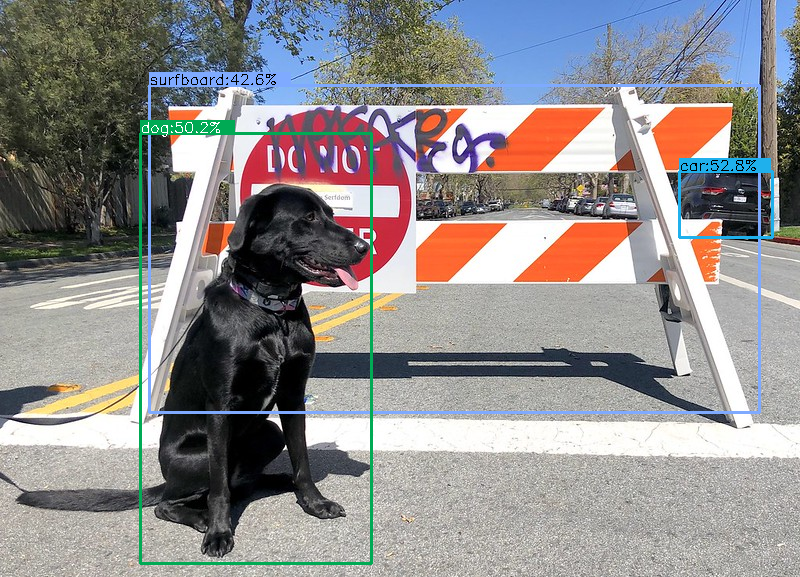

In [29]:
imshow_scale = 1.0
cv2_imshow(cv2.resize(result, None, fx=imshow_scale, fy=imshow_scale))

# Verify model accuracy

Setting up function to infer from the compiled OpenVINO model and returning results that are compatible with the pycocotools API for evaluation purposes. Pycocotools requires predictions in COCO format, hence we will first save our predictions in COCO format.

In [30]:
import pathlib
import json

In [43]:
def infer(img_path, imgId, results):

  meta, res = inference(img_path)
  dets = res[0]
  for label in dets:
    for bbox in dets[label]:
      score = bbox[4]
      if score > 0.35: #threshold
        r = {'score':np.float64(score),
            'image_id':imgId,
            'category_id':label,
            'bbox':list(np.array(bbox[:4]).astype(np.float64))}
        results.append(r)

## Downloading Dataset
The NanoDet model is trained on the COCO 
Since NanoDet models are trained with COCO-2017 dataset, we will use it's validation dataset to verify accuracy. 

In [ ]:
# Downloading Dataset and labels of COCO-VAL2017

from zipfile import ZipFile

DATA_URL = 'http://images.cocodataset.org/zips/val2017.zip'
LABELS_URL = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip'

OUT_DIR = pathlib.Path.cwd() / 'data'
OUT_DIR.mkdir(exist_ok=True)

if not (OUT_DIR / "coco/labels").exists():
    download_file(url=DATA_URL,directory=str(OUT_DIR))
    download_file(url=LABELS_URL,directory=str(OUT_DIR))
    with ZipFile('data/coco2017labels-segments.zip' , 'r') as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('data/val2017.zip' , 'r') as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

To evaluate performance, we will use AP metric ie. Average Precision for which you will use the COCO official API called pycocotools. 

In [61]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load the COCO validation set annotations
annFile = 'data/coco/annotations/instances_val2017.json'
cocoGt = COCO(annFile)

# Run inference on the validation set
results = []
imgIds = sorted(cocoGt.getImgIds())

for imgId in imgIds:
    imgInfo = cocoGt.loadImgs(imgId)[0]
    img_path = os.path.join(OUT_DIR, 'coco/images/val2017', imgInfo['file_name'])
    infer(img_path, imgId, results)

res_file = 'result.json'
with open(res_file,'w') as result_file:
    json.dump(results,result_file)

# Evaluate the results using the COCO API
cocoDt = cocoGt.loadRes(results)
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# Print mAP metric
print('mAP:', cocoEval.stats[0])

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets